#Team Details :
## CS23MTECH11020 - Suryansh Gautam
## CS23MTECH11008 - V Harikrishnan
## CS23MTECH11029 - Patel Heetkumar D.
## CS23MTECH13001 - Anil kumar Sharma
## CS23MTECH13002 - KR Anuraj


Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing necessary libraries

In [ ]:
import networkx as nx
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

Reading dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Payments.csv')

Calculating probability for outgoing edge from each node.

In [ ]:
def compute_probabilities(graph, probs, p, q):
  G = graph
  for source_node in G.nodes():
    for current_node in G.neighbors(source_node):
      prob_node = list()
      for destination in G.neighbors(current_node):

        if source_node == destination:
          prob = G[current_node][destination].get('weight', 1) * (1/p)
        elif destination in G.neighbors(source_node):
          prob = G[current_node][destination].get('weight', 1)
        else:
          prob = G[current_node][destination].get('weight', 1) * (1/q)

        prob_node.append(prob)

      probs[source_node]['probabilities'][current_node] = prob_node/np.sum(prob_node)

  return probs

Generating random walks

In [ ]:

def generate_random_walks(graph, probs, max_walks, walk_len):
  G = graph
  walks = list()
  for start_node in G.nodes():
    for i in range(max_walks):
      walk = [start_node]

      walk_options = list(G[start_node])
      if len(walk_options) == 0:
        break
      first_step = np.random.choice(walk_options)
      walk.append(first_step)

      for k in range(walk_len - 2):
        walk_options = list(G[walk[-1]])
        if len(walk_options) == 0:
          break

        probabilities = probs[walk[-2]]['probabilities'][walk[-1]]
        next_step = np.random.choice(walk_options, p=probabilities)
        walk.append(next_step)
      walks.append(walk)
  np.random.shuffle(walks)
  walks = [list(map(str, walk)) for walk in walks]

  return walks

Obtain embeddings from Word2Vec by passing walks

In [ ]:
def Node2Vec(generated_walks, window_size, embedding_dim):
  model = Word2Vec(sentences=generated_walks, window=window_size, vector_size=embedding_dim)
  return model.wv

Creating multi edge directional graph

In [ ]:
G = nx.MultiDiGraph()

for index, row in df.iterrows():
    sender = row['Sender']
    receiver = row['Receiver']
    amount = row['Amount']
    G.add_edge(sender, receiver, weight=np.log(amount))

In [ ]:
len(G.edges())

130535

In [ ]:
from collections import defaultdict

probs = defaultdict(dict)
for node in G.nodes():
  probs[node]['probabilities'] = dict()

In [ ]:
cp = compute_probabilities(G, probs, 2, 5)
walks = generate_random_walks(G, cp, 10, 10)
# walks

In [ ]:
n2v_emb = Node2Vec(walks, 5, 16)

In [ ]:
embeddings = n2v_emb.vectors

Fitting k means on the generated embeddings

In [ ]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=50)
kmeans.fit(embeddings)
labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting PCA on generated embeddings

In [ ]:
pca = PCA(n_components=2)

dim_2 = pca.fit_transform(embeddings)

Plotting the clusters that are generated using Node2Vec method

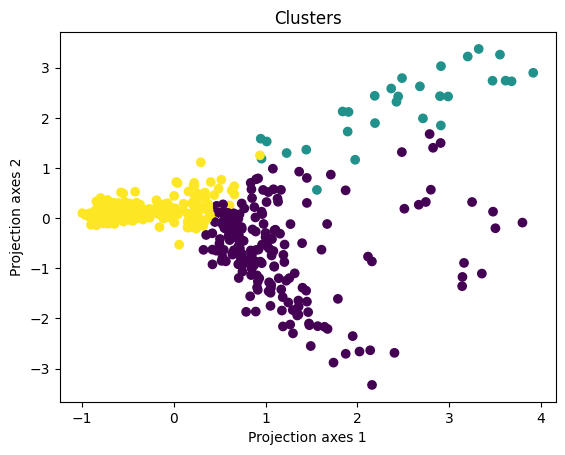

In [ ]:
plt.scatter(dim_2[:, 0], dim_2[:, 1], c=labels, cmap='viridis')
plt.title('Clusters')
plt.xlabel('Projection axes 1')
plt.ylabel('Projection axes 2')
plt.show()